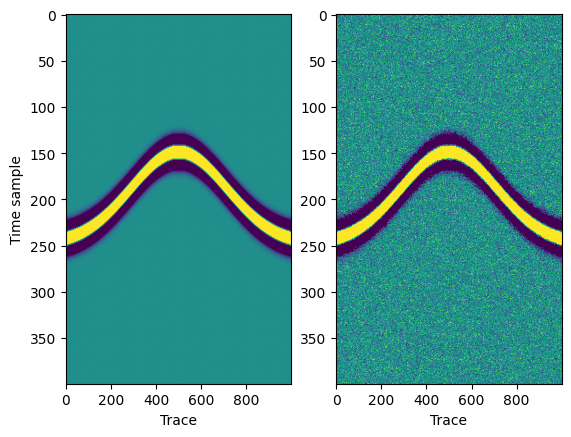

In [1]:
# Prepared On Oct 15, 2024 by Yangkang Chen, UT-Austin
#
# As a reproduced example for two papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
#
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n umltorch python=3.12.4
# conda activate umltorch
# conda install ipython notebook
# pip install matplotlib==3.9.1 torch==2.2.2 numpy==1.26.4 
# 
# GPU machine
# conda create -n umltorch python=3.12.4
# conda activate umltorch
# conda install ipython notebook
# pip install matplotlib==3.9.1 torch==2.2.2 numpy==1.26.4 
#
#
#generate data
import numpy as np
from pyseistr import gensyn
data,noisy=gensyn(noise=True);[n1,n2]=data.shape;
import matplotlib.pyplot as plt;
plt.subplot(1,2,1);plt.imshow(data,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');plt.ylabel('Time sample');
plt.subplot(1,2,2);plt.imshow(noisy,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');
plt.show();


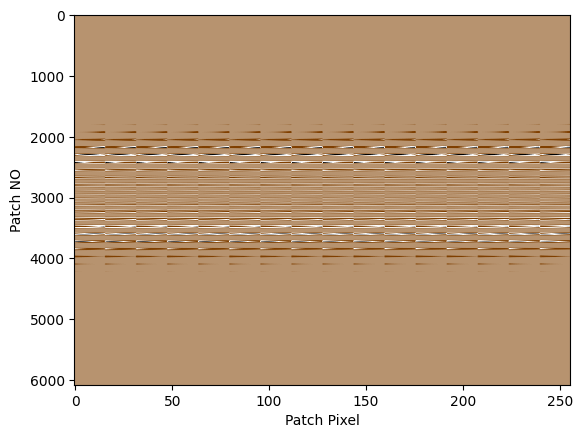

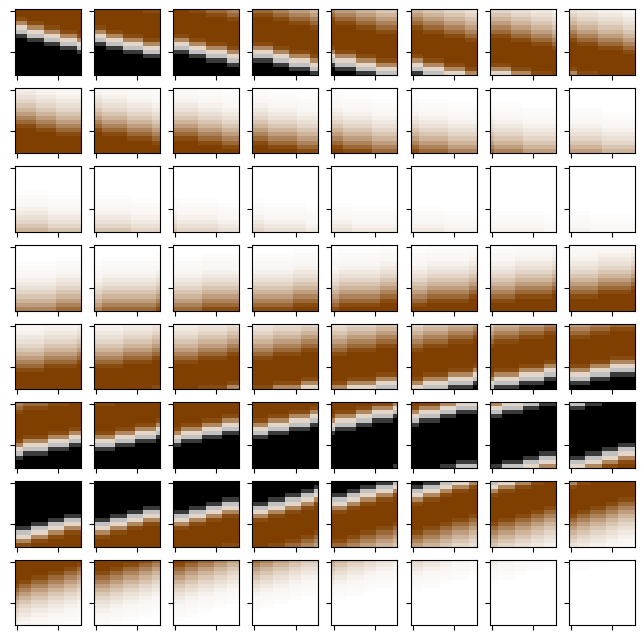

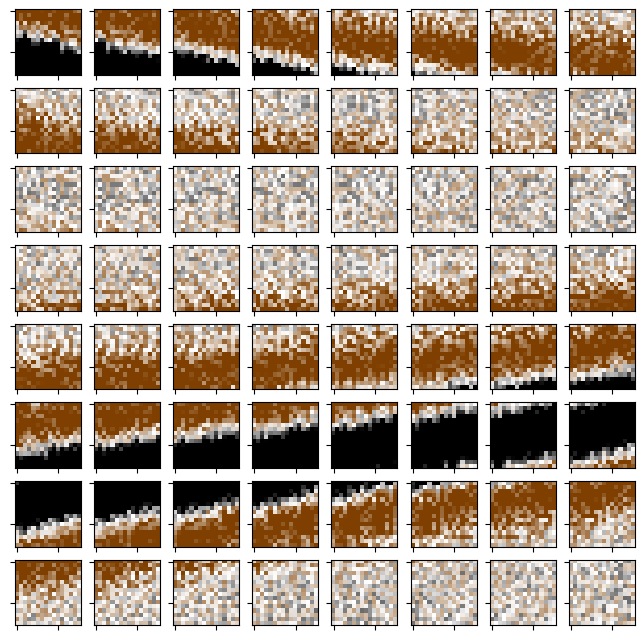

In [2]:
from pyseistr import patch2d,patch2d_inv,snr
X=patch2d(data,l1=16,l2=16,s1=8,s2=8);
Xnoisy=patch2d(noisy,l1=16,l2=16,s1=8,s2=8);

from pyseistr import cseis
plt.imshow(X,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(X[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


Using mps device
Epoch 1
-------------------------------
loss: 0.020068  [   64/ 6076]
Test Error (Avg loss): 1.986635 
Epoch 2
-------------------------------
loss: 0.013182  [   64/ 6076]
Test Error (Avg loss): 1.494694 
Epoch 3
-------------------------------
loss: 0.012581  [   64/ 6076]
Test Error (Avg loss): 1.351164 
Epoch 4
-------------------------------
loss: 0.012193  [   64/ 6076]
Test Error (Avg loss): 1.258811 
Epoch 5
-------------------------------
loss: 0.011857  [   64/ 6076]
Test Error (Avg loss): 1.195156 
Epoch 6
-------------------------------
loss: 0.011557  [   64/ 6076]
Test Error (Avg loss): 1.148231 
Epoch 7
-------------------------------
loss: 0.011276  [   64/ 6076]
Test Error (Avg loss): 1.119486 
Epoch 8
-------------------------------
loss: 0.011021  [   64/ 6076]
Test Error (Avg loss): 1.101361 
Epoch 9
-------------------------------
loss: 0.010802  [   64/ 6076]
Test Error (Avg loss): 1.088402 
Epoch 10
-------------------------------
loss: 0.010614 

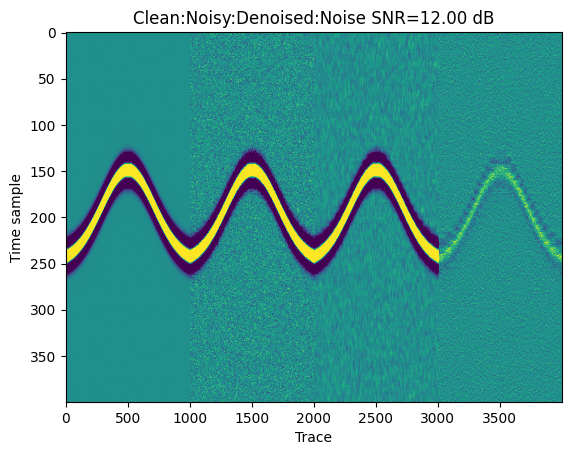

In [3]:

import os
import torch
from torch import nn
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

learning_rate = 0.001
batch_size = 64
# batch_size = 6076
epochs = 10

tensor_x = torch.Tensor(Xnoisy) # transform to torch tensor
tensor_y = torch.Tensor(Xnoisy)

my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size) # create your dataloader

train_dataloader=my_dataloader
test_dataloader =my_dataloader

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = 256),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # print('batch=',batch)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    print(f"Test Error (Avg loss): {test_loss:>8f} ")
    


# epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

preds=[]
for ii in train_dataloader:
    preds.append(model(ii[0]).detach().numpy())
# Xout=np.array(preds)
Xout=np.concatenate(preds,axis=0)

# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();



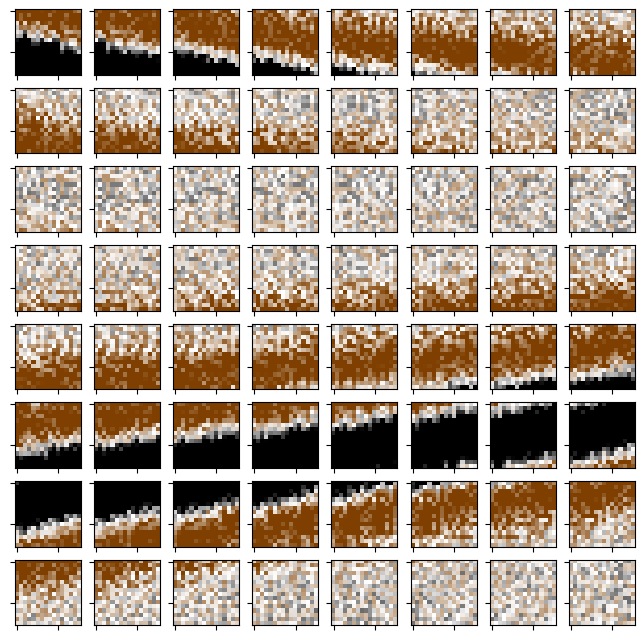

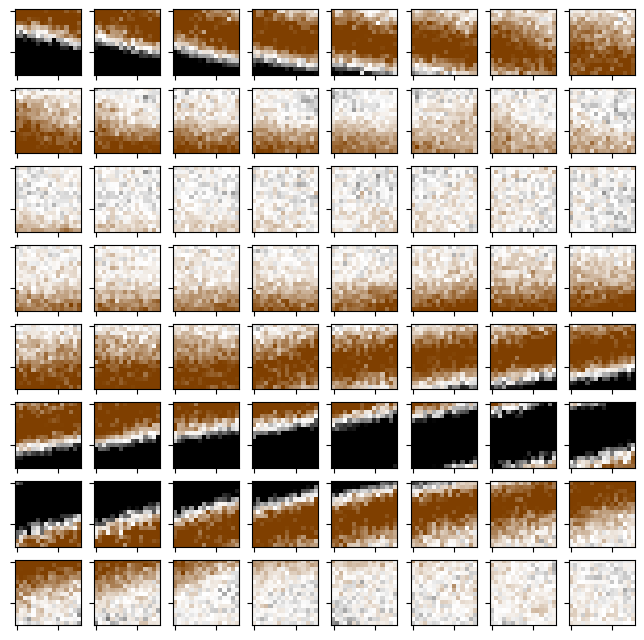

In [4]:
# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

Using mps device
Epoch 1
-------------------------------
loss: 0.016120  [    4/ 6076]


/Users/chenyk/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 256])) that is different to the input size (torch.Size([4, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.013251  [  404/ 6076]
loss: 0.013404  [  804/ 6076]
loss: 0.014084  [ 1204/ 6076]
loss: 0.013842  [ 1604/ 6076]
loss: 0.013490  [ 2004/ 6076]
loss: 0.236997  [ 2404/ 6076]
loss: 0.031191  [ 2804/ 6076]
loss: 0.239453  [ 3204/ 6076]
loss: 0.152510  [ 3604/ 6076]
loss: 0.014941  [ 4004/ 6076]
loss: 0.013722  [ 4404/ 6076]
loss: 0.013926  [ 4804/ 6076]
loss: 0.014426  [ 5204/ 6076]
loss: 0.012593  [ 5604/ 6076]
loss: 0.013092  [ 6004/ 6076]
Test Error (Avg loss): 49.992474 
Epoch 2
-------------------------------
loss: 0.013314  [    4/ 6076]
loss: 0.013168  [  404/ 6076]
loss: 0.013319  [  804/ 6076]
loss: 0.013901  [ 1204/ 6076]
loss: 0.013843  [ 1604/ 6076]
loss: 0.013180  [ 2004/ 6076]
loss: 0.375510  [ 2404/ 6076]
loss: 0.024902  [ 2804/ 6076]
loss: 0.240496  [ 3204/ 6076]
loss: 0.281628  [ 3604/ 6076]
loss: 0.013604  [ 4004/ 6076]
loss: 0.013632  [ 4404/ 6076]
loss: 0.013935  [ 4804/ 6076]
loss: 0.014439  [ 5204/ 6076]
loss: 0.012602  [ 5604/ 6076]
loss: 0.013131  [ 6004/ 60

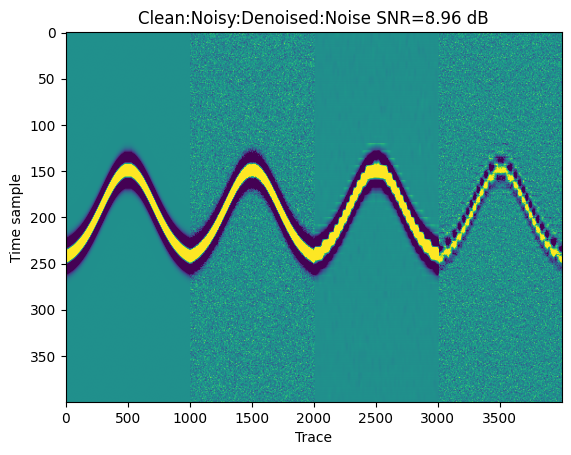

In [5]:
### PATCHUNET (no skip connections)
# A similar architecture (Conv -> Dense) is used in 
# Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.

import os
import torch
from torch import nn
from torch.utils.data import DataLoader

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

learning_rate = 0.001
batch_size = 4
# batch_size = 6076
epochs = 5

tensor_x = torch.Tensor(Xnoisy).reshape(6076,1,256) # transform to torch tensor
tensor_y = torch.Tensor(Xnoisy).reshape(6076,1,256) # 1 denotes Channel NO (different from the DenseLayer in the last example

my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size) # create your dataloader

train_dataloader=my_dataloader
test_dataloader =my_dataloader

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = 256),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class BasicDense1(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.dense1(x)
        return logits
        
class BasicDense2(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense2 = nn.Sequential(
            nn.Linear(in_features, out_features),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.dense2(x)
        return logits
        
class UNet1(nn.Module):
    def __init__(self):
        super(UNet1, self).__init__()

        self.encoder1 = BasicDense1(256, 128)
        self.encoder2 = BasicDense1(128, 64)
        self.encoder3 = BasicDense1(64, 32)
        self.encoder4 = BasicDense1(32, 16)
        self.encoder5 = BasicDense1(16, 8)
        self.encoder6 = BasicDense1(8, 4)

        self.decoder6 = BasicDense1(4, 4)
        self.decoder5 = BasicDense1(4, 8)
        self.decoder4 = BasicDense1(8, 16)
        self.decoder3 = BasicDense1(16,32)
        self.decoder2 = BasicDense1(32,64)
        self.decoder1 = BasicDense1(64,128)

        self.linear = BasicDense2(128,256)
        # self.decoder1 = BasicDense2(128,256)
        
        # self.conv = nn.Conv1d(
        #     in_channels=features, out_channels=out_channels, kernel_size=1
        # )

        self._init_weight()

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        # enc5 = self.encoder5(enc4)
        # enc6 = self.encoder6(enc5)
        # dec6 = self.decoder6(enc6)        
        # dec5 = self.decoder5(dec6)
        # dec4 = self.decoder4(dec5)
        dec3 = self.decoder3(enc4)
        dec2 = self.decoder2(dec3)
        dec1 = self.decoder1(dec2)

        out = self.linear(dec1)
        # out = self.linear(enc1)
        return out

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, a=0.2)
                
# model = NeuralNetwork()
model = UNet1()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # print('batch=',batch)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    print(f"Test Error (Avg loss): {test_loss:>8f} ")
    


# epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

preds=[]
for ii in train_dataloader:
    preds.append(model(ii[0]).detach().numpy())
# Xout=np.array(preds)
Xout=np.concatenate(preds,axis=0)

# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();




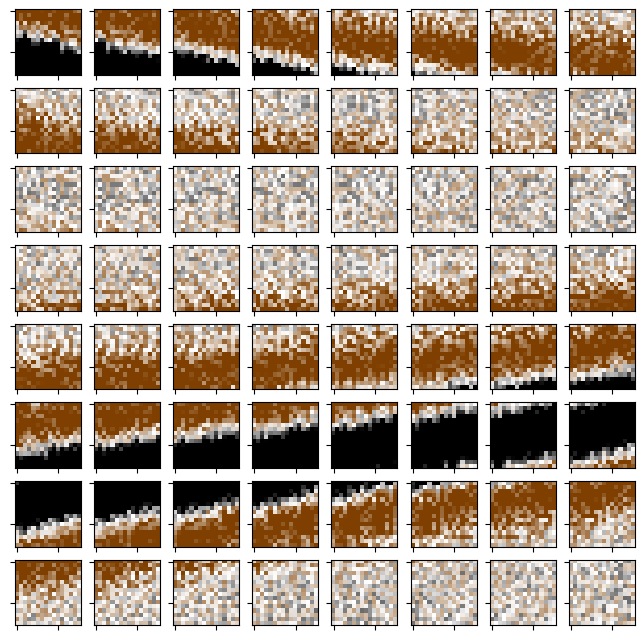

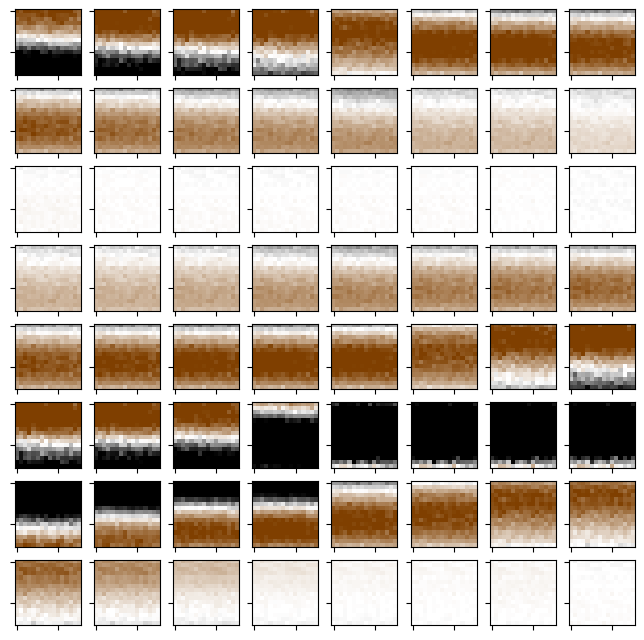

In [6]:
# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

Using mps device
Epoch 1
-------------------------------
loss: 0.018672  [    4/ 6076]
loss: 0.013576  [  404/ 6076]
loss: 0.013521  [  804/ 6076]
loss: 0.014158  [ 1204/ 6076]
loss: 0.013835  [ 1604/ 6076]
loss: 0.013218  [ 2004/ 6076]
loss: 0.514897  [ 2404/ 6076]
loss: 0.025615  [ 2804/ 6076]
loss: 0.114039  [ 3204/ 6076]
loss: 0.083118  [ 3604/ 6076]
loss: 0.013967  [ 4004/ 6076]
loss: 0.013690  [ 4404/ 6076]
loss: 0.014000  [ 4804/ 6076]
loss: 0.014380  [ 5204/ 6076]
loss: 0.012593  [ 5604/ 6076]
loss: 0.013062  [ 6004/ 6076]
Test Error (Avg loss): 33.176838 
Epoch 2
-------------------------------
loss: 0.013218  [    4/ 6076]
loss: 0.013079  [  404/ 6076]
loss: 0.013224  [  804/ 6076]
loss: 0.013829  [ 1204/ 6076]
loss: 0.013725  [ 1604/ 6076]
loss: 0.012873  [ 2004/ 6076]
loss: 0.212678  [ 2404/ 6076]
loss: 0.020684  [ 2804/ 6076]
loss: 0.089630  [ 3204/ 6076]
loss: 0.052945  [ 3604/ 6076]
loss: 0.013600  [ 4004/ 6076]
loss: 0.013536  [ 4404/ 6076]
loss: 0.013878  [ 4804/ 6076]

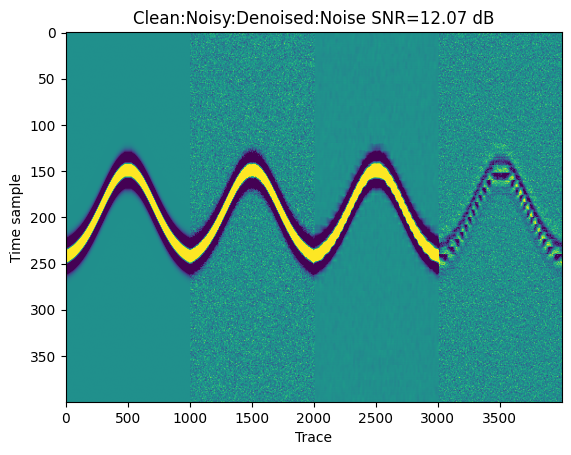

In [7]:
### PATCHUNET (with skip connections)
# A similar architecture (Conv -> Dense) is used in 
# Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.
# This part has not been verified (help me if you know how to make DenseLayer-style Skip Connection (UNet) properly.

import os
import torch
from torch import nn
from torch.utils.data import DataLoader

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

learning_rate = 0.001
batch_size = 4
# batch_size = 6076
epochs = 5

tensor_x = torch.Tensor(Xnoisy).reshape(6076,1,256) # transform to torch tensor
tensor_y = torch.Tensor(Xnoisy).reshape(6076,1,256) # 1 denotes Channel NO (different from the DenseLayer in the last example

my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size) # create your dataloader

train_dataloader=my_dataloader
test_dataloader =my_dataloader

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = 256),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class BasicDense1(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.dense1(x)
        return logits
        
class BasicDense2(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense2 = nn.Sequential(
            nn.Linear(in_features, out_features),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.dense2(x)
        return logits
        
class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()

        self.encoder1 = BasicDense1(256, 128)
        self.encoder2 = BasicDense1(128, 64)
        self.encoder3 = BasicDense1(64, 32)
        self.encoder4 = BasicDense1(32, 16)
        self.encoder5 = BasicDense1(16, 8)
        self.encoder6 = BasicDense1(8, 4)

        self.decoder6 = BasicDense1(4, 4)
        self.decoder5 = BasicDense1(4, 8)
        self.decoder4 = BasicDense1(8, 16)
        self.decoder3 = BasicDense1(16,32)
        self.decoder2 = BasicDense1(32,64)
        self.decoder1 = BasicDense1(64,128)

        self.linear = BasicDense2(128,256)
        # self.decoder1 = BasicDense2(128,256)
        
        # self.conv = nn.Conv1d(
        #     in_channels=features, out_channels=out_channels, kernel_size=1
        # )

        self._init_weight()

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)
        enc6 = self.encoder6(enc5)

        dec6 = self.decoder6(enc6)
        # dec6 = torch.cat((dec6, enc6), dim=0)
        dec6 = dec6+enc6;
        
        dec5 = self.decoder5(dec6)
        dec5 = dec5+enc5;
        # dec5 = torch.cat((dec5, enc5), dim=0)
        
        dec4 = self.decoder4(dec5)
        dec4 = dec4+enc4;
        # dec4 = torch.cat((dec4, enc4), dim=0)

        dec3 = self.decoder3(enc4)
        dec3 = dec3+enc3;
        # dec3 = torch.cat((dec3, enc3), dim=0)

        dec2 = self.decoder2(dec3)
        dec2 = dec2+enc2;
        # dec2 = torch.cat((dec2, enc2), dim=0)

        dec1 = self.decoder1(dec2)
        dec1 = dec1+enc1;
        # dec1 = torch.cat((dec1, enc1), dim=0)

        out = self.linear(dec1)
        # out = self.linear(enc1)
        return out

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, a=0.2)
                
# model = NeuralNetwork()
# model = UNet1()
model = UNet2()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # print('batch=',batch)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    print(f"Test Error (Avg loss): {test_loss:>8f} ")
    


# epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

preds=[]
for ii in train_dataloader:
    preds.append(model(ii[0]).detach().numpy())
# Xout=np.array(preds)
Xout=np.concatenate(preds,axis=0)

# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();




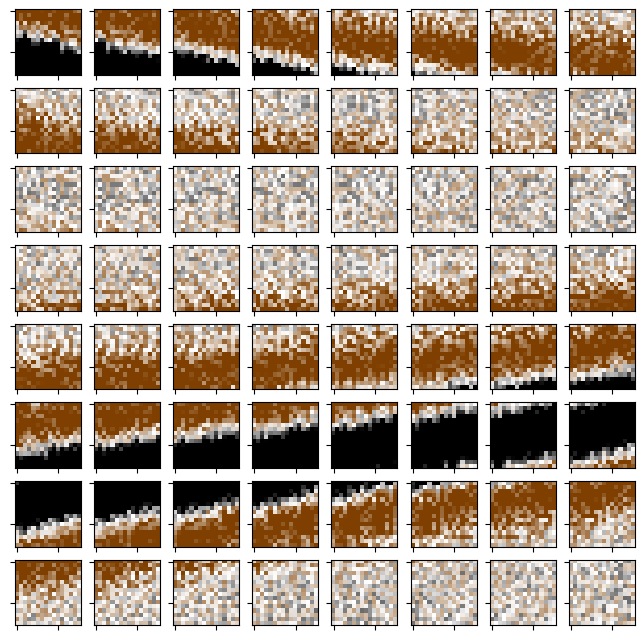

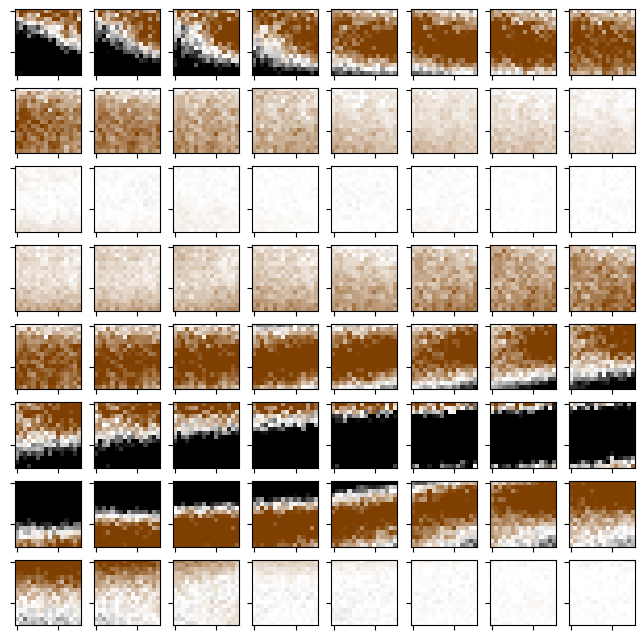

In [8]:
# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()